In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from acc_features import GenerateFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from xgboost import XGBClassifier




In [ ]:
# features.drop(['center_time', 'start_time', 'end_time', 'gyr_x_permutation_entropy', 'gyr_y_permutation_entropy', 'gyr_z_permutation_entropy', 'gyr_mag_permutation_entropy', 'gyr_x_spectral_entropy', 'gyr_y_spectral_entropy', 'gyr_z_spectral_entropy', 'gyr_mag_spectral_entropy'], axis=1, inplace=True)
features = pd.read_csv('/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/feature_based_data/three_class_up_1s_new.csv')
features.drop(['center_time', 'start_time', 'end_time'], axis= 1, inplace=True)
# df = features.loc[:, ~features.columns.str.contains('_energy$|_min$|_max$|_entropy$')]  # Drops columns starting with 'user'
features.head()


,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,acc_x_min,acc_x_max,acc_x_time_energy,...,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_energy,label,experiment_id
0,0.840598,0.524760,0.938842,1.134729,5.349532,1.472764,1.287610,-1.100002,4.24953,127.972959,...,0.950861,4.338769,1.989574,0.904136,0.107588,4.446357,233.545858,13779.205614,pre-void,1
1,0.833607,0.520173,0.989449,1.158952,5.349532,1.523870,1.343169,-1.100002,4.24953,137.008536,...,0.974930,4.338769,1.987275,0.950488,0.107588,4.446357,233.006397,13747.377440,pre-void,1
2,0.823753,0.562236,1.193638,1.186426,5.349532,1.682967,1.407606,-1.100002,4.24953,167.110329,...,1.031948,4.338769,2.169826,1.064918,0.107588,4.446357,277.780664,16389.059150,pre-void,1
3,0.837070,0.566957,1.251707,1.200011,5.349532,1.734012,1.440027,-1.100002,4.24953,177.401031,...,1.012218,4.338769,2.173449,1.024585,0.107588,4.446357,278.708959,16443.828570,pre-void,1
4,0.815424,0.582808,1.165694,1.210199,5.349532,1.680305,1.464581,-1.100002,4.24953,166.582012,...,1.084391,4.338769,2.106941,1.175903,0.107588,4.446357,261.912788,15452.854511,pre-void,1


In [5]:
# features = df

View label distribution

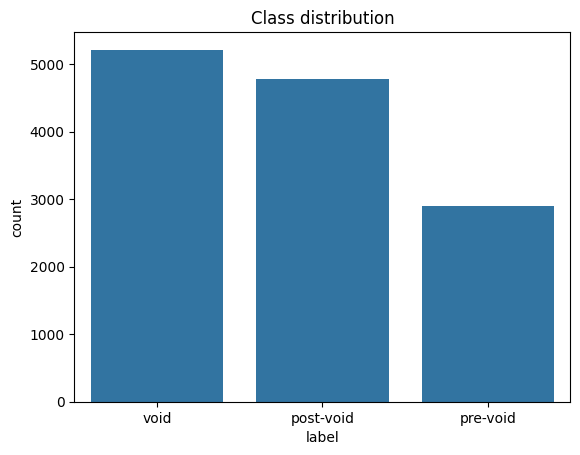

In [6]:
plt.figure()
sns.countplot(x = 'label',
              data = features,
              order = features.label.value_counts().index)
plt.title('Class distribution')
plt.show()

In [7]:
features.label.value_counts()

label
void         5216
post-void    4788
pre-void     2907
Name: count, dtype: int64

In [8]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [9]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Now train XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="multi:softprob",
    eval_metric='mlogloss',
    # reg_alpha=0.1,   # L1 regularization
    # reg_lambda=1.0,  # L2 regularization
    # early_stopping_rounds=10,
    # scale_pos_weight=1.27,
    verbosity=0, 
    # booster=True
)

eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]
model.fit(X_train, y_train_encoded, eval_set=eval_set, verbose=False)  # Use encoded labels

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [10]:
# Classification report
y_pred = label_encoder.inverse_transform(model.predict(X_test))
y_pred_prob = model.predict_proba(X_test)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred)

# import json
# with open('model_plots/unsampled_2secs/cr_2sec.json', 'w') as f:
#     json.dump(report, f, indent=4)
    
print(report)

              precision    recall  f1-score   support

   post-void       0.55      0.53      0.54      1484
    pre-void       0.30      0.40      0.34       637
        void       0.60      0.53      0.56      1340

    accuracy                           0.51      3461
   macro avg       0.48      0.49      0.48      3461
weighted avg       0.52      0.51      0.51      3461



In [11]:
acc_score = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
print(f"The score on the training set is accuracy: {acc_score:0.4f} and the AUC is {auc_score: 0.4f}")

The score on the training set is accuracy: 0.5051 and the AUC is  0.6692


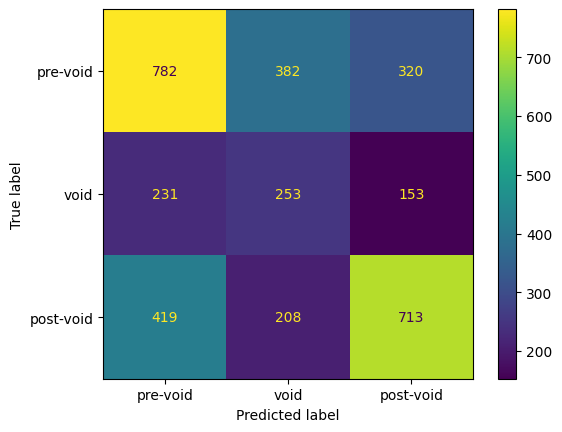

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['pre-void', 'void', 'post-void'])
cm_display.plot()
plt.show()
# plt.savefig('model_plots/unsampled_2secs/cm_2sec.png')


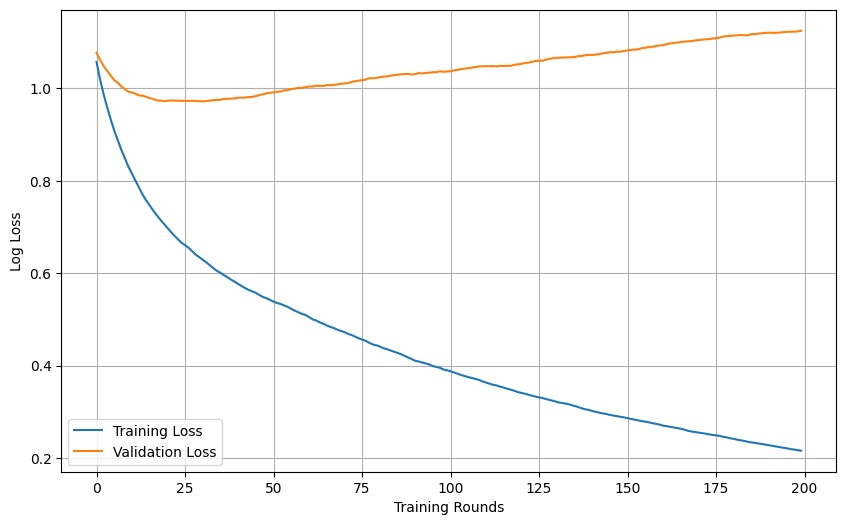

In [13]:
# Retrieve the evaluation results
results = model.evals_result()
train_loss = results['validation_0']['mlogloss']
test_loss = results['validation_1']['mlogloss']

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Training Rounds')
plt.ylabel('Log Loss')
# plt.title('Loss')
plt.legend()
plt.grid(True)
# plt.savefig('model_plots/unsampled_2secs/unsampled_loss_2sec.png')

Cross validation using GroupKFold

In [14]:
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import accuracy_score, classification_report
# import numpy as np

# # Setup GroupKFold
# gkf = GroupKFold(n_splits=5)  # 5-fold cross-validation
# scores = []
# auc_scores = []

# # Perform cross-validation
# for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
#     print(f"Fold {fold + 1}")
    
#     # Split data
#     X_train_fold = X.iloc[train_idx]
#     X_val_fold = X.iloc[val_idx]
#     y_train_fold = y.iloc[train_idx]
#     y_val_fold = y.iloc[val_idx]
    
#     # Encode labels
#     y_train_encoded = label_encoder.fit_transform(y_train_fold)
#     y_test_encoded = label_encoder.transform(y_val_fold)
    
#     # Train model
#     model = XGBClassifier(
#         n_estimators=200,
#         max_depth=5,
#         learning_rate=0.1,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         objective="multi:softprob",
#         eval_metric='mlogloss',
#         reg_alpha=0.1,   # L1 regularization
#         reg_lambda=1.0,  # L2 regularization
#         verbosity=0
#     )
#     model.fit(X_train_fold, y_train_encoded)
    
#     # Evaluate
#     y_pred = model.predict(X_val_fold)
#     y_pred_prob = model.predict_proba(X_val_fold)
#     y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
    
#     score = accuracy_score(y_test_encoded, y_pred)
#     scores.append(score)
    
#     auc_score = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr', average='macro')
#     auc_scores.append(auc_score)
    
    
#     print(f"Validation Accuracy: {acc_score:.4f}")
#     print(f"Unique groups in train: {X_train.index.map(lambda x: groups.iloc[x]).nunique()}")
#     print(f"Unique groups in val: {X_test.index.map(lambda x: groups.iloc[x]).nunique()}")
#     print("-" * 50)

# # Overall results
# print(f"Mean CV Score: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")
# print(f"Mean ROC_AUC Score: {np.mean(auc_scores)}")